# Temat 3: Wielowarstwowy perceptron i algorytm wstecznej propagacji błędu

In [11]:
from IPython.display import Image
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


## Zadanie 3.1

Przeanalizować implementację klasy
wielowarstwowego perceptronu (z jedną warstwą ukrytą, sigmoidalną funkcją aktywacji oraz średniokwadratową funkcją straty) oraz implementacje
funkcji
`minibatch_generator()`,
`mse_loss()`,
`accuracy()`,
`compute_mse_and_acc()`
oraz
`train()` (notebook do wykładu).

In [12]:
# Funckja fetch_openml (z scikit-learn) pobiera zbiór danych MNIST 
# z OpenML (https://www.openml.org/d/554) jako obiekty typu DataFrame i Series z pandas
# (dlatego używamy atrybutu .values, aby otrzymać tablicę NumPy).

from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/Users/jedrzejsarna/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


In [13]:
# Normalizacja cech do przedziału [-1,1]
# (pod optymalizację metodą gradientową):
X = ((X / 255.) - .5) * 2

Podzielmy ten zbiór danych na zbiór uczący, zbiór walidacyjny oraz zbiór testowy (55 000 + 5 000 + 10 000):

In [14]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
#del X_temp, y_temp, X, y

## Implementacja wielowarstwowego perceptronu
z jedną warstwą ukrytą, sigmoidalną funkcją aktywacji, MSE jako funkcja straty

In [15]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


# Do konertowania etykiet liczbowych na wektorowe one-hot:
def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    # Inicjalizacja macierzy wag i wektora obciążenia dla warstwy ukrytej oraz dla warstwy wyjściowej:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

## Proces uczenia sieci

In [16]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# Sprawdzenie, czy powyższa funkcja działa poprawnie
# (zaczynamy iterację po zbiorze danych, przerywamy i wypisujemy rozmiar mini-wsadu)

# Iterujemy po epokach:
for i in range(num_epochs):

    # Iterujemy po mini-wsadach
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Kolejne funkcje implementują funkcję straty oraz funkcję błędu klasyfikacji (potrzebne do oceny jakości modelu oraz monitorowania procesu uczenia sieci).

In [17]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


# UWAGA: jeśli mamy zainicjalizowany model
# Test powyższych funkcji (liczymy MSE na zbiorze walidacyjnym
# dla zainicjalizowanego modelu oraz błąd tego modelu):

Jeśli będziemy ograniczeni przez pamięć naszego komputera i w konsekwencji nie będziemy mogli wykonać metody `forward` na całym zbiorze danych (łatwo do tego doprowadzić, bo w grę wchodzi mnożenie ogromnych macierzy), to jakość modelu trzeba mierzyć i uaktualniać na kolejnych mini-wsadach. Na tej zasadzie działa poniższa funkcja.

In [18]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

Funkcja `train()` implementuje cały proces uczenia sieci o rozważanej w bieżącym przykładzie architekturze.

Funkcja zwraca bieżącą (epoka po epoce) wartość funkcji straty na zbiorze treningowym oraz bieżącą dokładność modelu na zbiorze treningowym i na zabiorze walidacyjnym.

In [19]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

## Zadanie 3.2

Dla przykładu klasyfikacji cyfr utworzyć obiekt klasy `NeuralNetMLP` z 50 neuronami w warstwie ukrytej. Następnie przeprowadzić proces uczenia tego modelu przez 50 epok. Przyjąć `learning_rate=0.1`. Obserwując jakość modelu w trakcie uczenia go, możemy wyłapać sytuację złego doboru hiperparametrów (niska jakość na zb. treningowym i walidacyjnym) lub przeuczenie modelu (duża rozbieżność pomiędzy jakością modelu na zbiorze treningowym a jakością na zbiorze walidacyjnym). Wówczas przerywamy proces uczenia.

Czy któryś z tych efektów jest widoczny w procesie uczenia z tego zadania?

In [20]:
model = NeuralNetMLP(num_features=X_train.shape[1], num_hidden=50, num_classes=10)

In [21]:
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.18% | Valid Acc: 76.26%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.61% | Valid Acc: 85.30%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.16% | Valid Acc: 87.96%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.33% | Valid Acc: 89.36%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.17% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.64% | Valid Acc: 90.42%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.05% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.44% | Valid Acc: 91.00%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.81% | Valid Acc: 91.48%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.06% | Valid Acc: 91.82%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.23% | Valid Acc: 92.10%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.42% | Valid Acc: 92.02%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.69% | Valid Acc: 92.40%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.84

Wygląda jakby model cały czas się uczył? (lepsza jakość zarówno na zbiorze treningowym, co oczywiste, jak i zbiorze walidacyjnym).

In [22]:
epoch_loss2, epoch_train_acc2, epoch_valid_acc2 = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.01 | Train Acc: 95.64% | Valid Acc: 94.66%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 95.75% | Valid Acc: 94.78%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 95.74% | Valid Acc: 94.78%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 95.78% | Valid Acc: 94.98%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 95.83% | Valid Acc: 94.74%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 95.87% | Valid Acc: 94.84%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 95.90% | Valid Acc: 94.84%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 95.96% | Valid Acc: 94.94%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 95.98% | Valid Acc: 95.04%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 96.01% | Valid Acc: 94.96%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 96.03% | Valid Acc: 95.10%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 96.09% | Valid Acc: 95.16%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 96.10% | Valid Acc: 95.16%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 96.09

In [24]:
epoch_loss3, epoch_train_acc3, epoch_valid_acc3 = train(model, X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=0.1)

Epoch: 001/100 | Train MSE: 0.01 | Train Acc: 97.03% | Valid Acc: 95.86%
Epoch: 002/100 | Train MSE: 0.01 | Train Acc: 97.02% | Valid Acc: 95.82%
Epoch: 003/100 | Train MSE: 0.01 | Train Acc: 97.03% | Valid Acc: 95.80%
Epoch: 004/100 | Train MSE: 0.01 | Train Acc: 97.09% | Valid Acc: 95.92%
Epoch: 005/100 | Train MSE: 0.01 | Train Acc: 97.08% | Valid Acc: 95.90%
Epoch: 006/100 | Train MSE: 0.01 | Train Acc: 97.05% | Valid Acc: 95.88%
Epoch: 007/100 | Train MSE: 0.01 | Train Acc: 97.09% | Valid Acc: 95.84%
Epoch: 008/100 | Train MSE: 0.01 | Train Acc: 97.13% | Valid Acc: 95.90%
Epoch: 009/100 | Train MSE: 0.01 | Train Acc: 97.14% | Valid Acc: 96.02%
Epoch: 010/100 | Train MSE: 0.01 | Train Acc: 97.17% | Valid Acc: 95.94%
Epoch: 011/100 | Train MSE: 0.01 | Train Acc: 97.19% | Valid Acc: 96.00%
Epoch: 012/100 | Train MSE: 0.01 | Train Acc: 97.19% | Valid Acc: 96.08%
Epoch: 013/100 | Train MSE: 0.01 | Train Acc: 97.16% | Valid Acc: 96.08%
Epoch: 014/100 | Train MSE: 0.01 | Train Acc: 97.28

## Zadanie 3.3

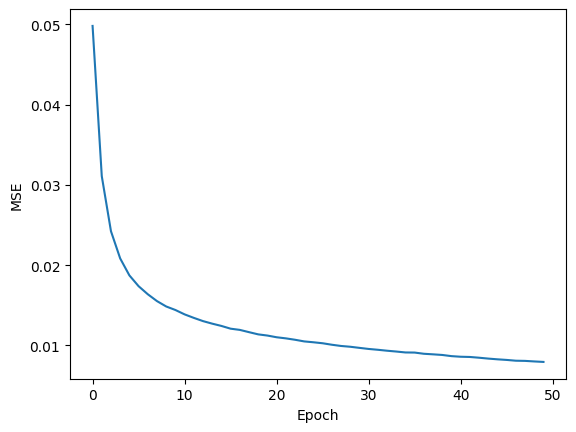

In [25]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.show()

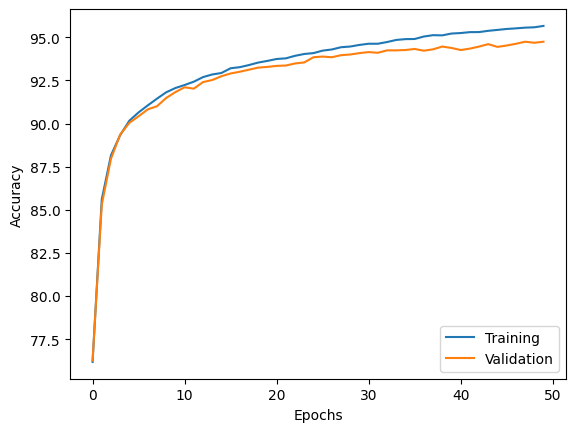

In [26]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.show()

Na początku (przez pierwsze 8-10 epok) model szybko się uczy. Dokładność modelu szybko się zwiększa, zarówno na zbiorze treningowym jak i walidacyjnym, a błąd średniokwadratowy szybko maleje (chociaz od początku jest on niski). Po pewnym czasie mamy rozbieność między dokładnością na zbiorze treningowym oraz walidacyjnym i ta róznica zwiększa się (w pewien sposób liniowo) wraz ze wzrostem liczby epok. Popatrzmy na wyniki dla kolejnych epok.

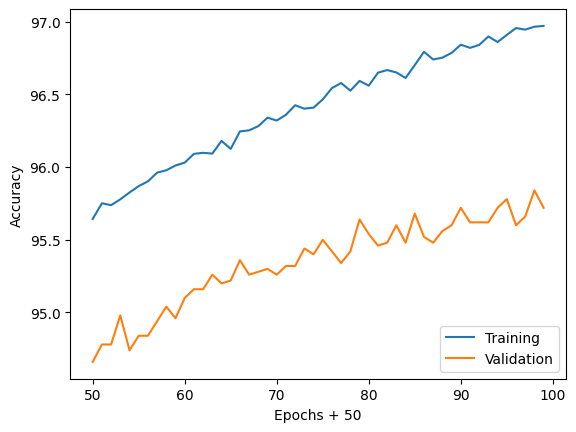

In [34]:
plt.plot(range(50,len(epoch_train_acc2)+50), epoch_train_acc2,
         label='Training')
plt.plot(range(50,len(epoch_valid_acc2)+50), epoch_valid_acc2,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs + 50')
plt.legend(loc='lower right')

plt.show()

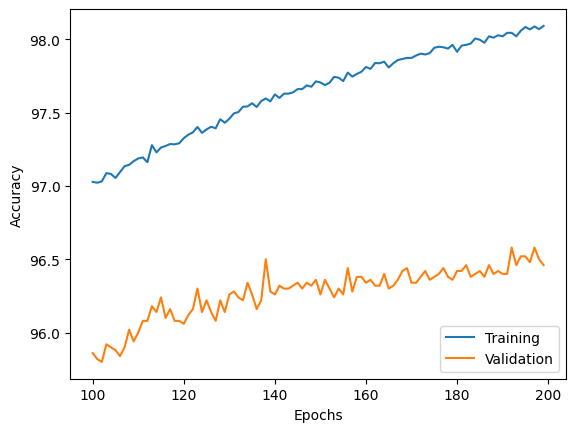

In [33]:
plt.plot(range(100,len(epoch_train_acc3)+100), epoch_train_acc3,
         label='Training')
plt.plot(range(100,len(epoch_valid_acc3)+100), epoch_valid_acc3,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.show()

Ogólnie chyba nie wygląda tutaj na scenariusz przeuczenia, model jest dobrze zdefiniowany? Hiperparamtery sa dobrze dobrane co pokazuja wyniki na zbiorze walidacyjnym?